<a href="https://colab.research.google.com/github/itsvamz/AgriPulse/blob/main/Crop_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima
!pip install statsmodels

In [ ]:
!pip install prophet
!pip install pandas-profiling

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn.ensemble import RandomForestRegressor
import requests

In [ ]:

# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d racksonsit/prices-of-all-agricultural-commodity
!unzip prices-of-all-agricultural-commodity.zip

data = pd.read_excel('Date-Wise-Prices-all-Commodity.xlsx')

Dataset URL: https://www.kaggle.com/datasets/racksonsit/prices-of-all-agricultural-commodity
License(s): unknown
prices-of-all-agricultural-commodity.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  prices-of-all-agricultural-commodity.zip
replace Date-Wise-Prices-all-Commodity.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Date-Wise-Prices-all-Commodity.xlsx  


In [ ]:
# Convert Arrival_Date to datetime with dayfirst=True
data['Arrival_Date'] = pd.to_datetime(data['Arrival_Date'], dayfirst=True)

# Check the result
print(data['Arrival_Date'].head())


0   2023-02-24
1   2023-02-24
2   2023-02-24
3   2023-02-24
4   2023-02-24
Name: Arrival_Date, dtype: datetime64[ns]


In [ ]:
#Reverse the order of the dataset so that the latest year data will arrive in the tail of the dataframe
data = data.iloc[::-1]

In [ ]:
#View the dataset
data.head(20)

,diffgr:id,msdata:rowOrder,State,District,Market,Commodity,Variety,Grade,Arrival_Date,Min_x0020_Price,Max_x0020_Price,Modal_x0020_Price
6434,Table6435,6434,West Bengal,Sounth 24 Parganas,Diamond Harbour(South 24-pgs),Tomato,Tomato,FAQ,2023-02-24,1400,1600.0,1500.0
6433,Table6434,6433,West Bengal,Sounth 24 Parganas,Diamond Harbour(South 24-pgs),Rice,Super Fine,FAQ,2023-02-24,4700,4900.0,4800.0
6432,Table6433,6432,West Bengal,Sounth 24 Parganas,Diamond Harbour(South 24-pgs),Rice,Common,FAQ,2023-02-24,2700,2900.0,2800.0
6431,Table6432,6431,West Bengal,Sounth 24 Parganas,Diamond Harbour(South 24-pgs),Potato,Jyoti,FAQ,2023-02-24,760,800.0,780.0
6430,Table6431,6430,West Bengal,Sounth 24 Parganas,Diamond Harbour(South 24-pgs),Onion,Red,FAQ,2023-02-24,1400,1500.0,1450.0
6429,Table6430,6429,West Bengal,Sounth 24 Parganas,Diamond Harbour(South 24-pgs),Green Chilli,Green Chilly,FAQ,2023-02-24,5200,5400.0,5300.0
6428,Table6429,6428,West Bengal,Sounth 24 Parganas,Diamond Harbour(South 24-pgs),Fish,Katla(Big),FAQ,2023-02-24,21500,22500.0,22000.0
6427,Table6428,6427,West Bengal,Sounth 24 Parganas,Diamond Harbour(South 24-pgs),Cucumbar(Kheera),Cucumbar,FAQ,2023-02-24,3400,3600.0,3500.0
6426,Table6427,6426,West Bengal,Sounth 24 Parganas,Diamond Harbour(South 24-pgs),Brinjal,Brinjal,FAQ,2023-02-24,4300,4500.0,4400.0
6425,Table6426,6425,West Bengal,Sounth 24 Parganas,Baruipur(Canning),Rice,Super Fine,FAQ,2023-02-24,4400,4600.0,4500.0


In [ ]:
data.isnull().sum()

,0
diffgr:id,0
msdata:rowOrder,0
State,0
District,0
Market,0
Commodity,0
Variety,0
Grade,0
Arrival_Date,0
Min_x0020_Price,0


In [ ]:
data.dtypes

,0
diffgr:id,object
msdata:rowOrder,int64
State,object
District,object
Market,object
Commodity,object
Variety,object
Grade,object
Arrival_Date,datetime64[ns]
Min_x0020_Price,int64


In [ ]:
data.duplicated().sum()

0

In [ ]:
#Use date column as the index
data.reset_index(inplace=True)

In [ ]:
data.head()

,index,diffgr:id,msdata:rowOrder,State,District,Market,Commodity,Variety,Grade,Arrival_Date,Min_x0020_Price,Max_x0020_Price,Modal_x0020_Price
0,6434,Table6435,6434,West Bengal,Sounth 24 Parganas,Diamond Harbour(South 24-pgs),Tomato,Tomato,FAQ,2023-02-24,1400,1600.0,1500.0
1,6433,Table6434,6433,West Bengal,Sounth 24 Parganas,Diamond Harbour(South 24-pgs),Rice,Super Fine,FAQ,2023-02-24,4700,4900.0,4800.0
2,6432,Table6433,6432,West Bengal,Sounth 24 Parganas,Diamond Harbour(South 24-pgs),Rice,Common,FAQ,2023-02-24,2700,2900.0,2800.0
3,6431,Table6432,6431,West Bengal,Sounth 24 Parganas,Diamond Harbour(South 24-pgs),Potato,Jyoti,FAQ,2023-02-24,760,800.0,780.0
4,6430,Table6431,6430,West Bengal,Sounth 24 Parganas,Diamond Harbour(South 24-pgs),Onion,Red,FAQ,2023-02-24,1400,1500.0,1450.0


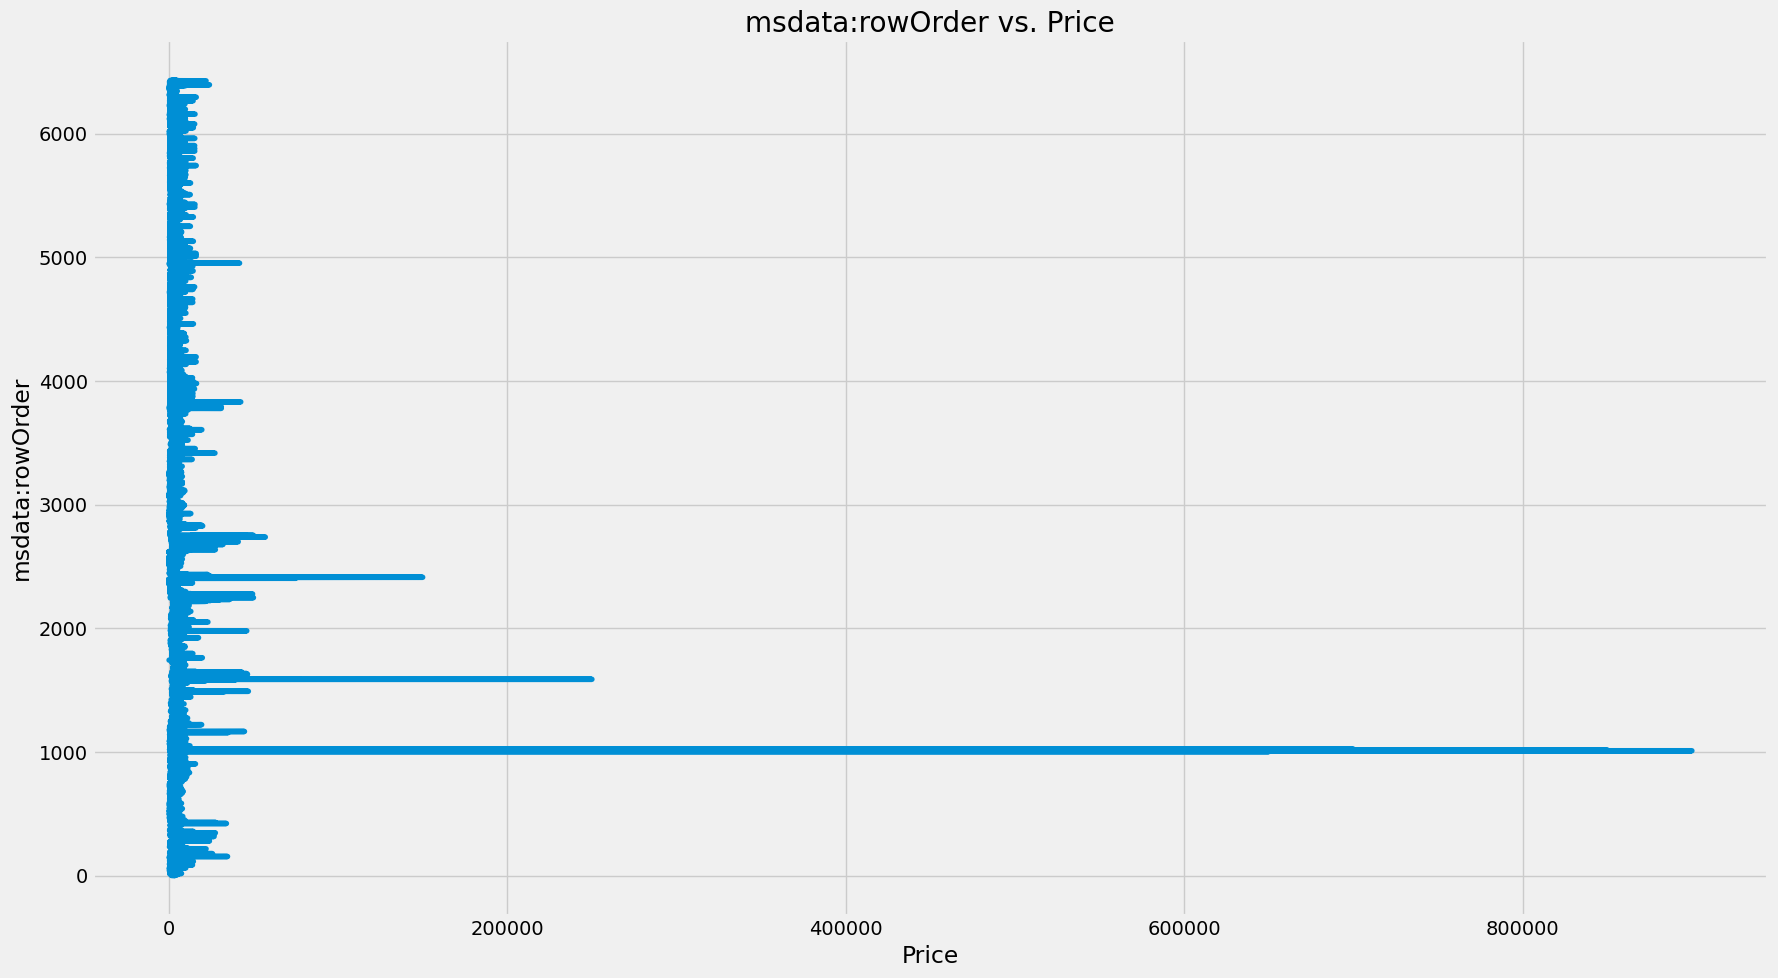

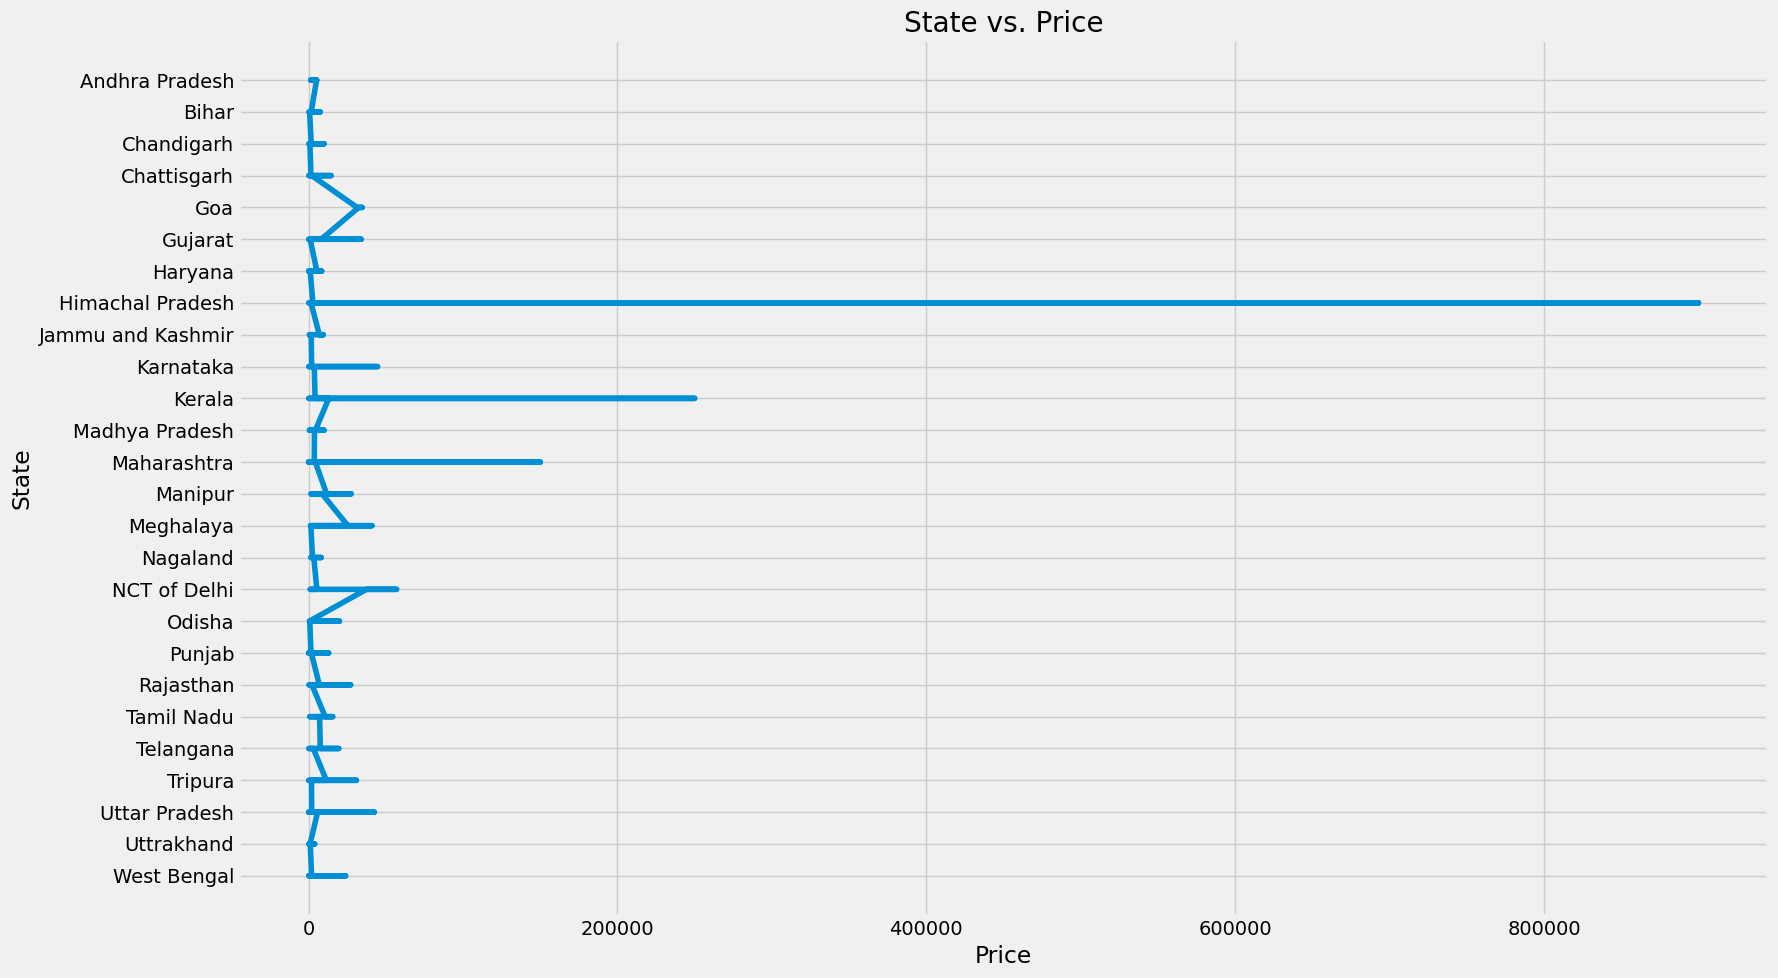

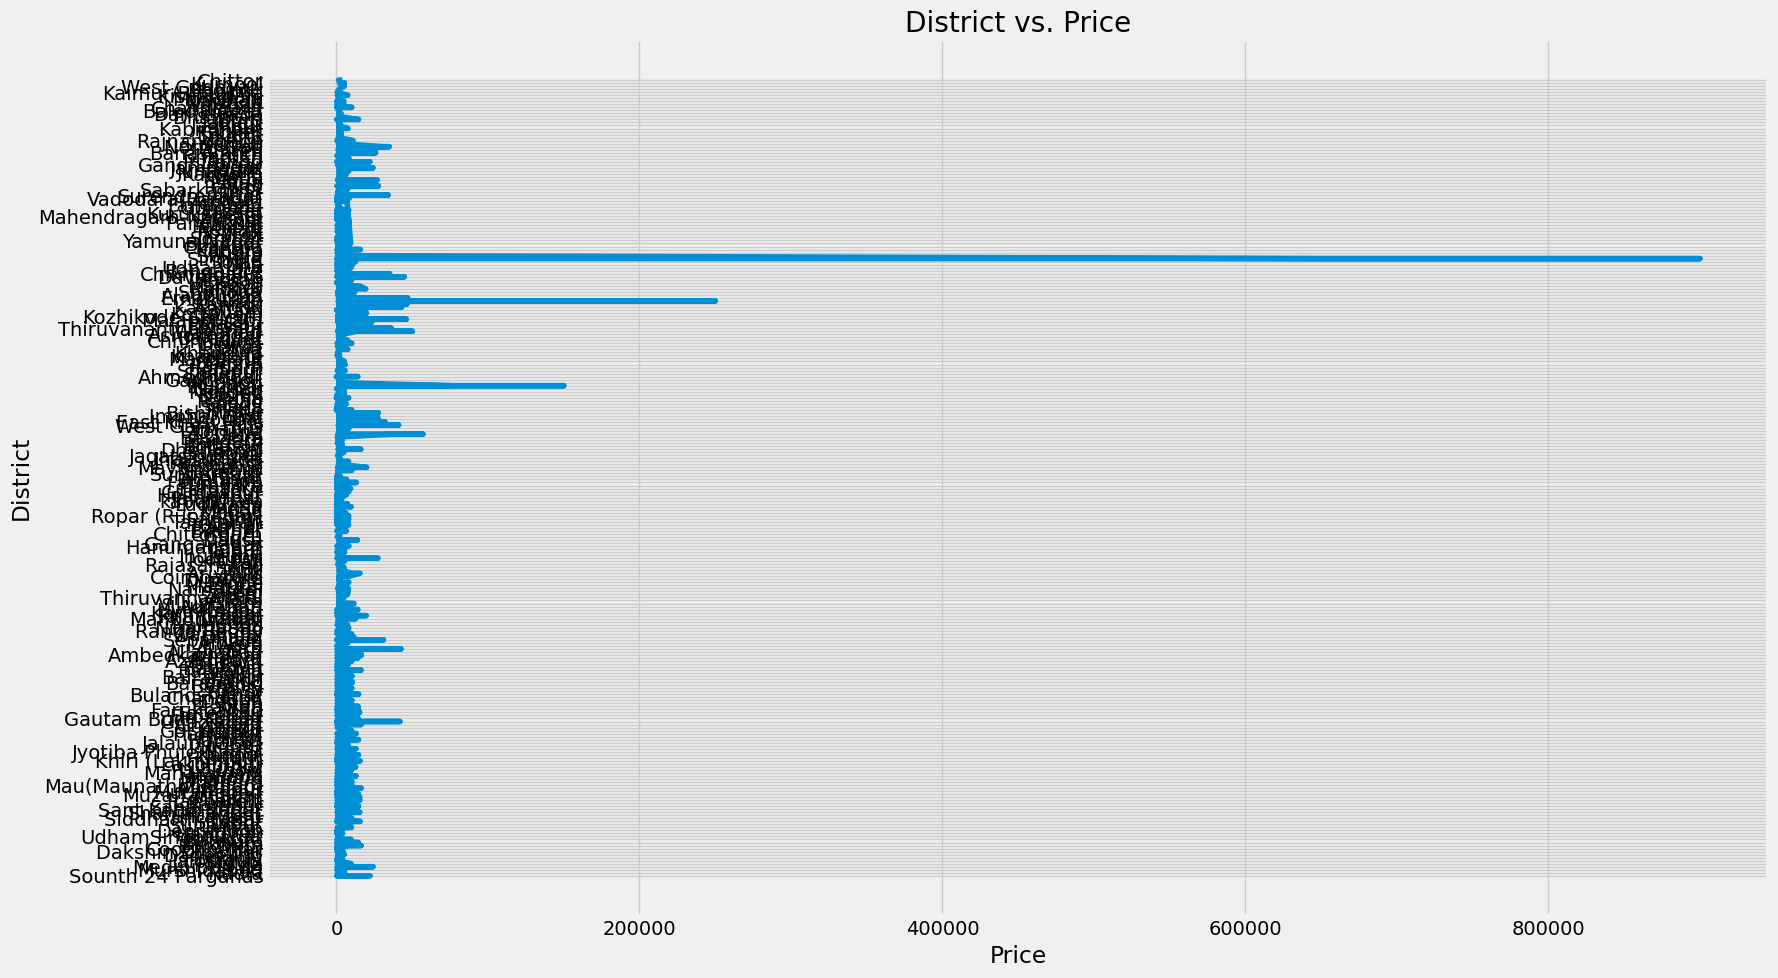

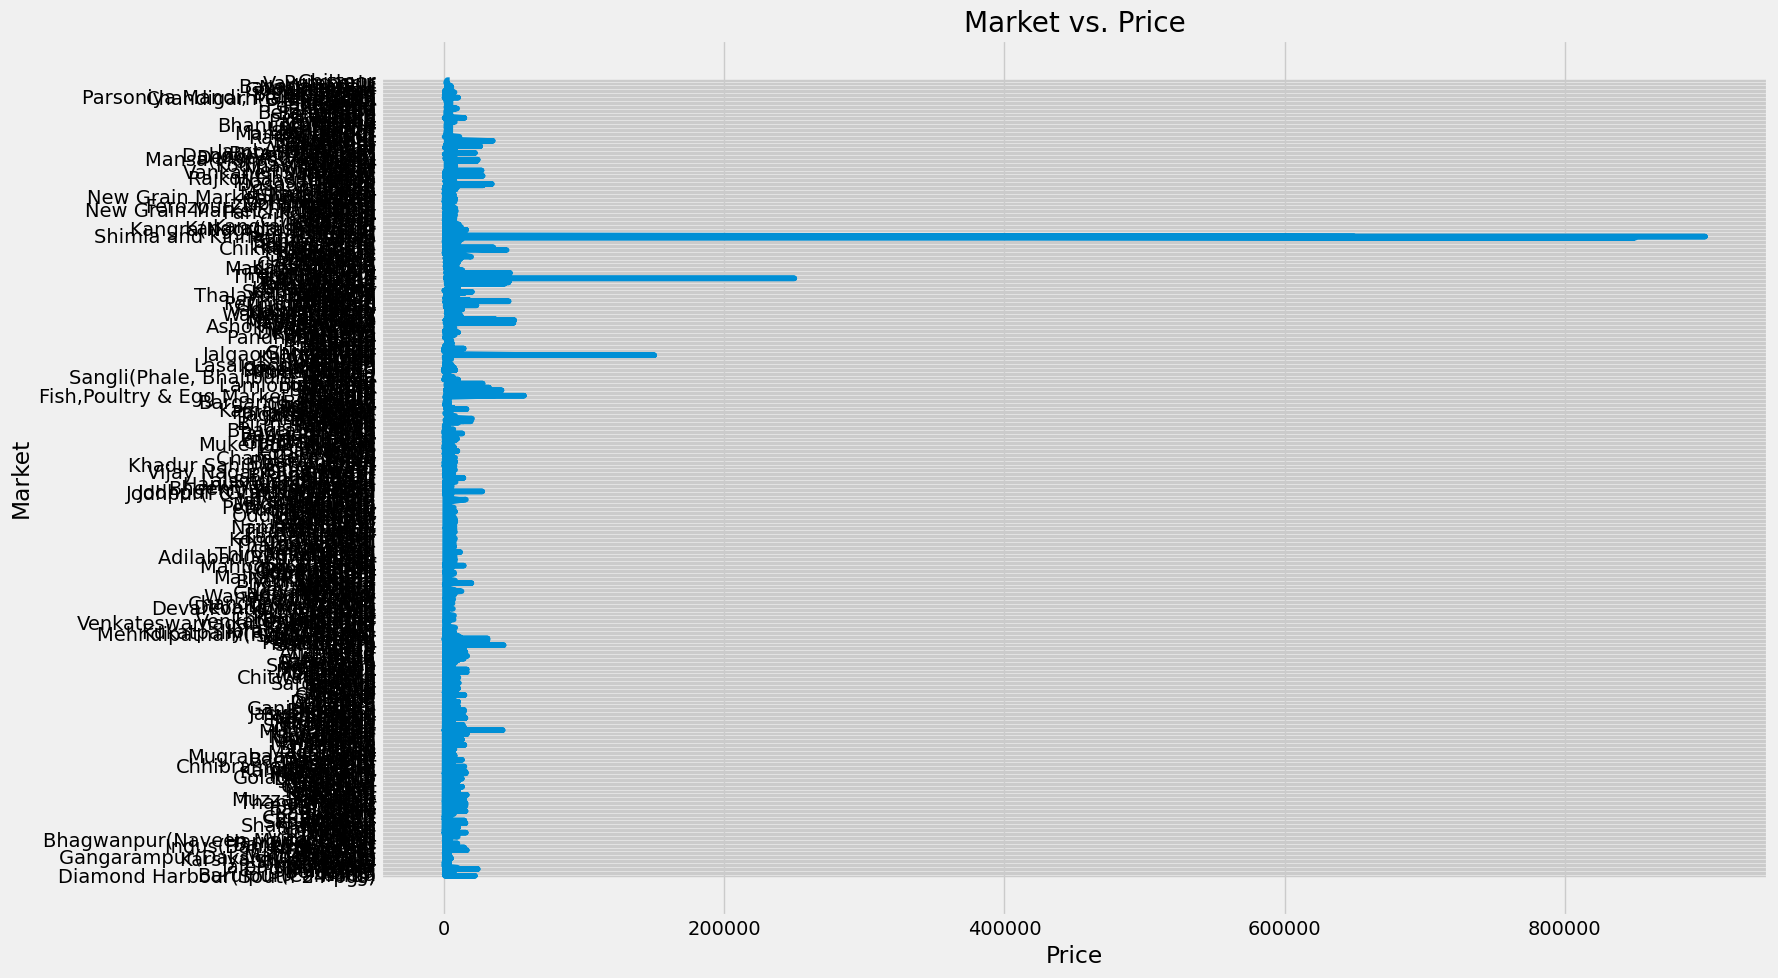

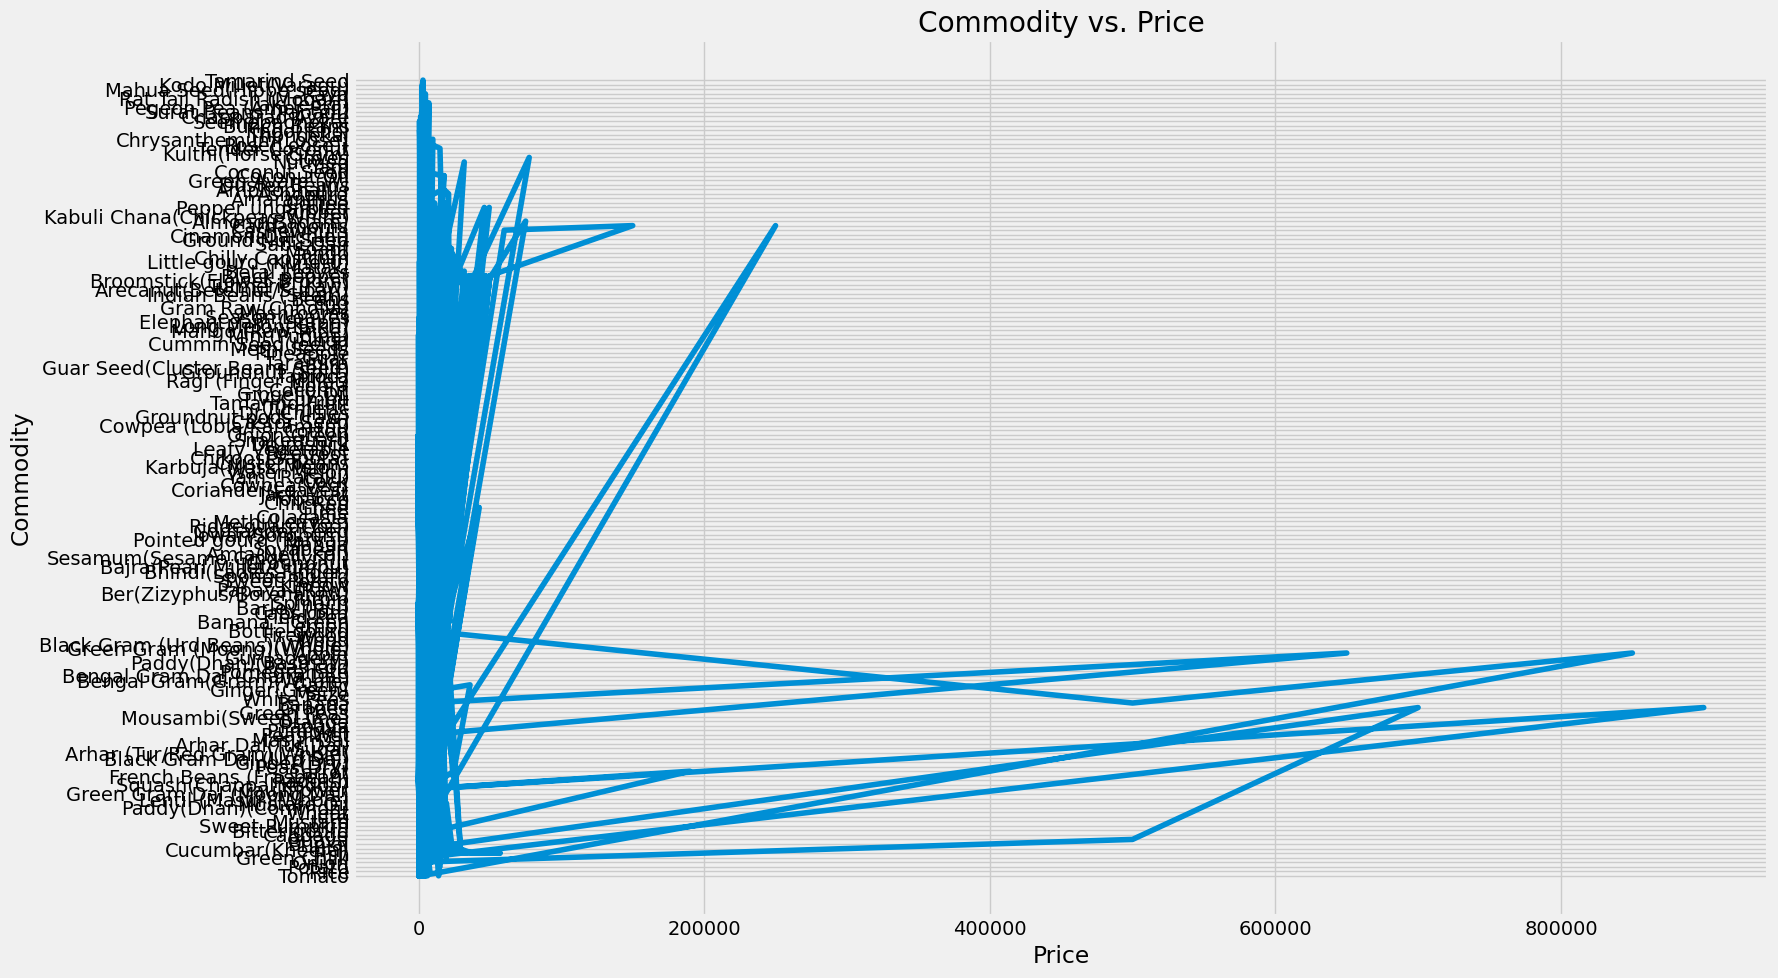

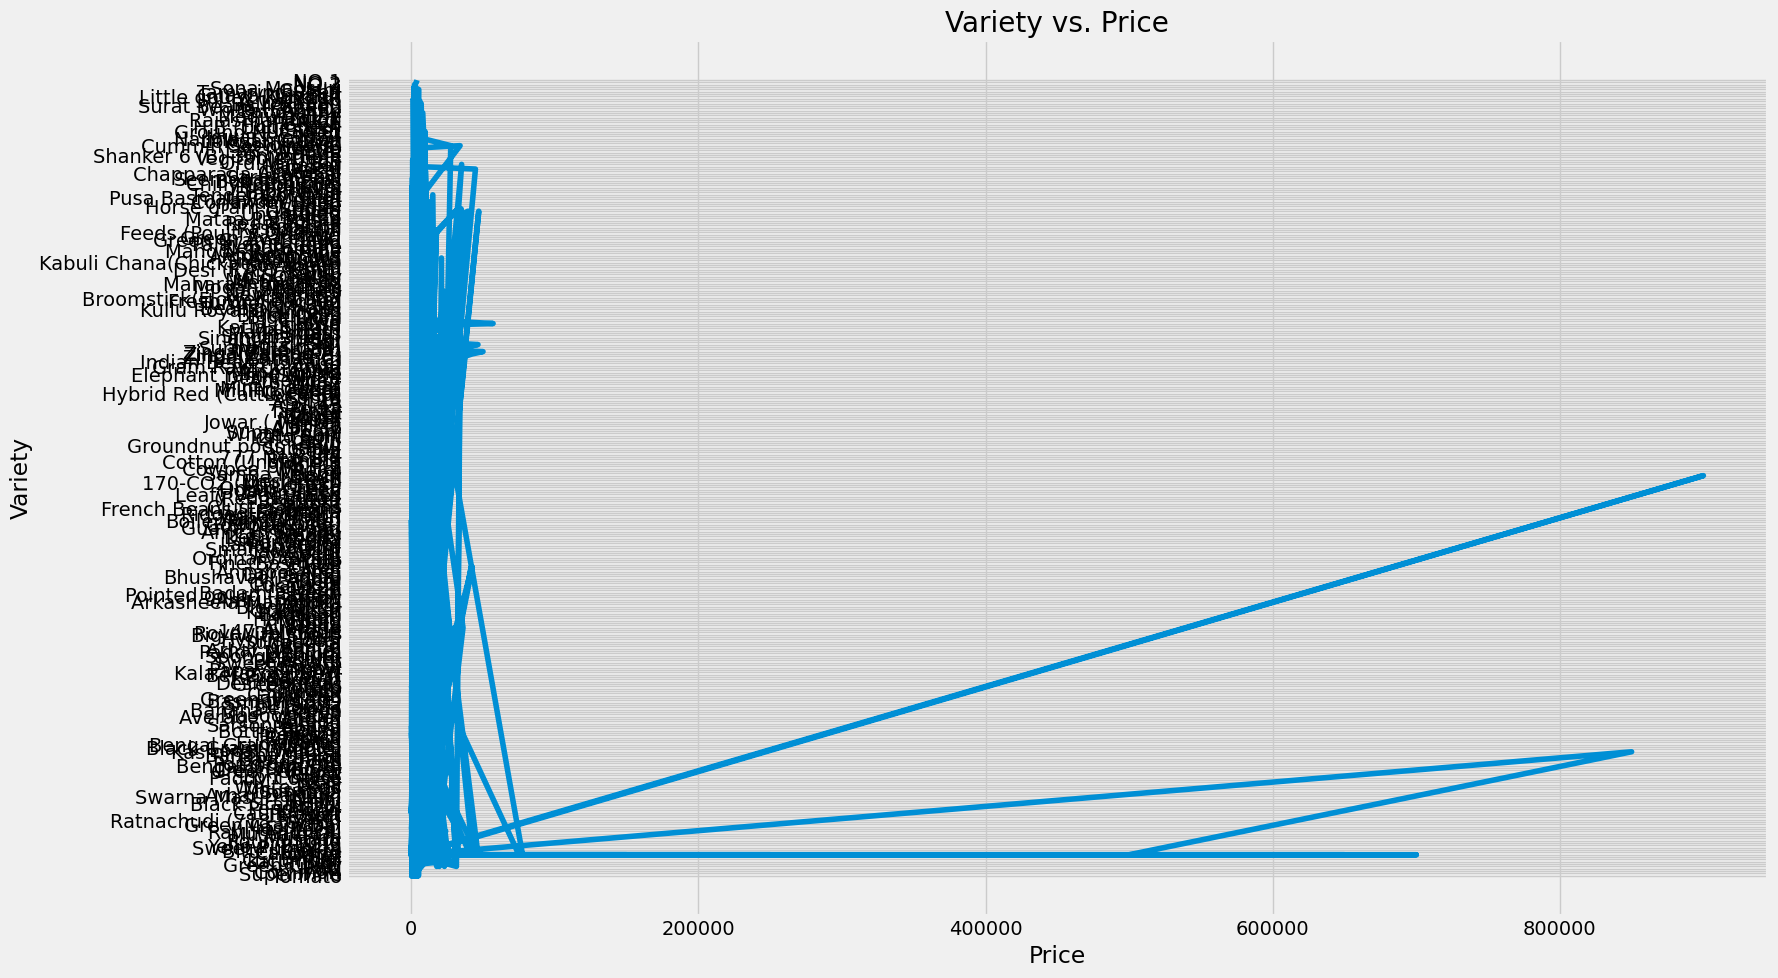

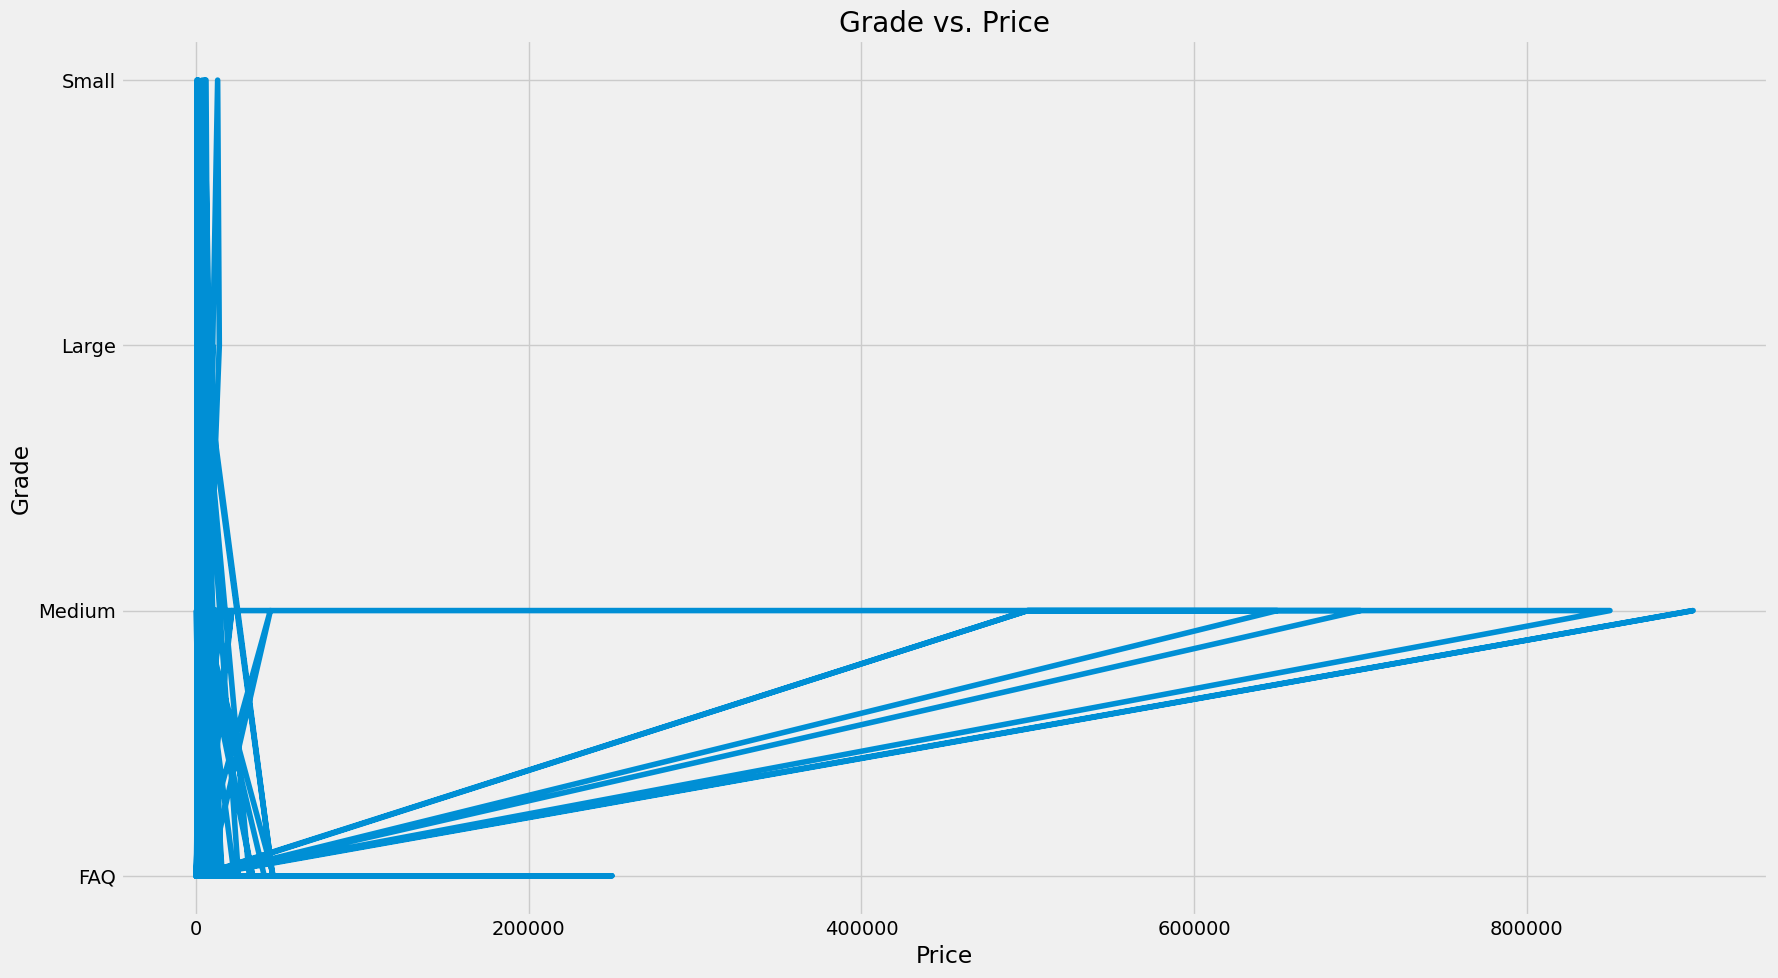

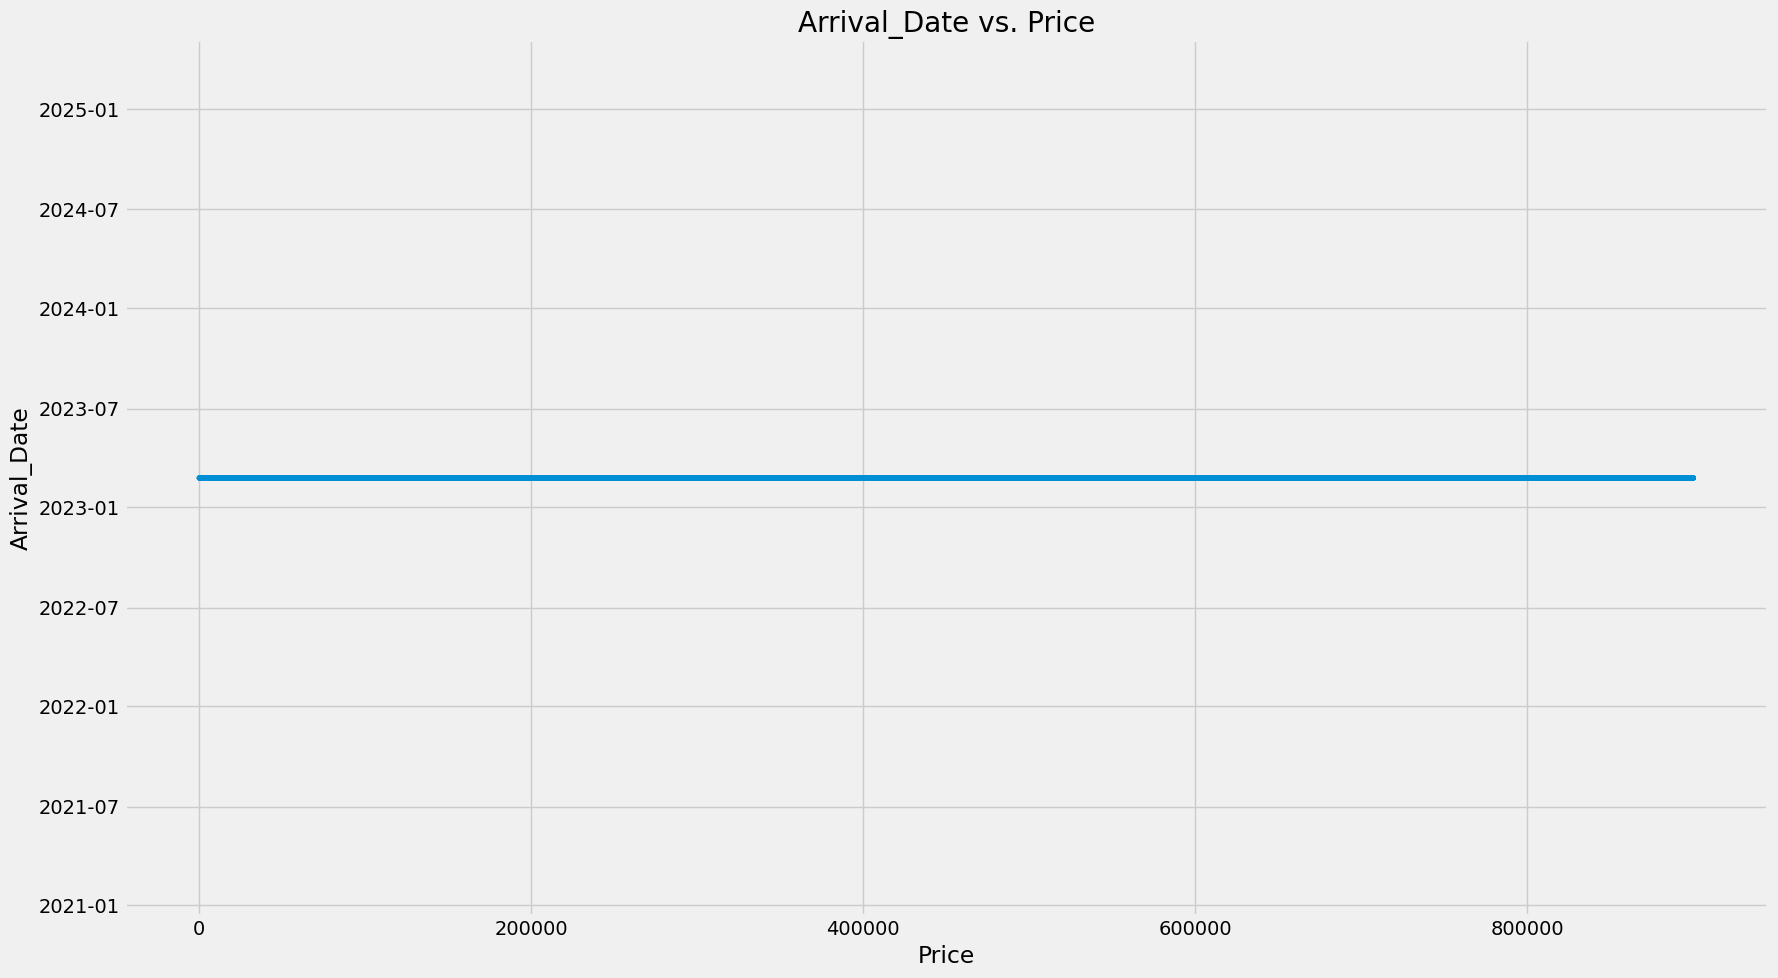

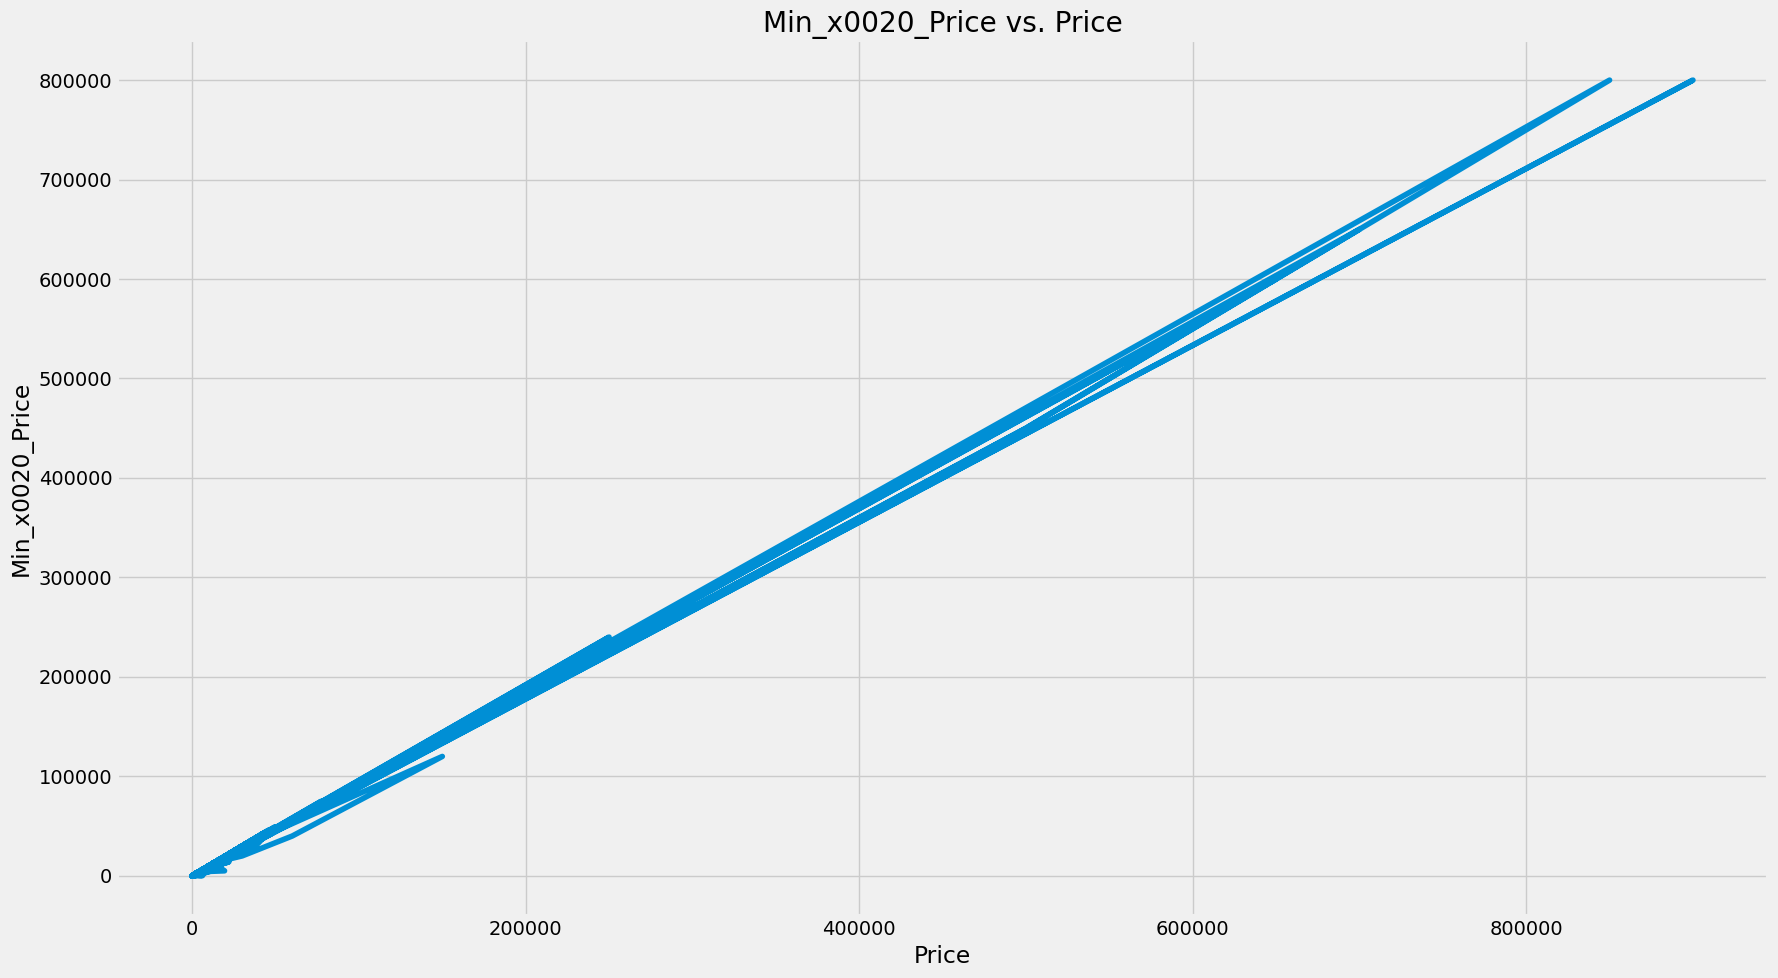

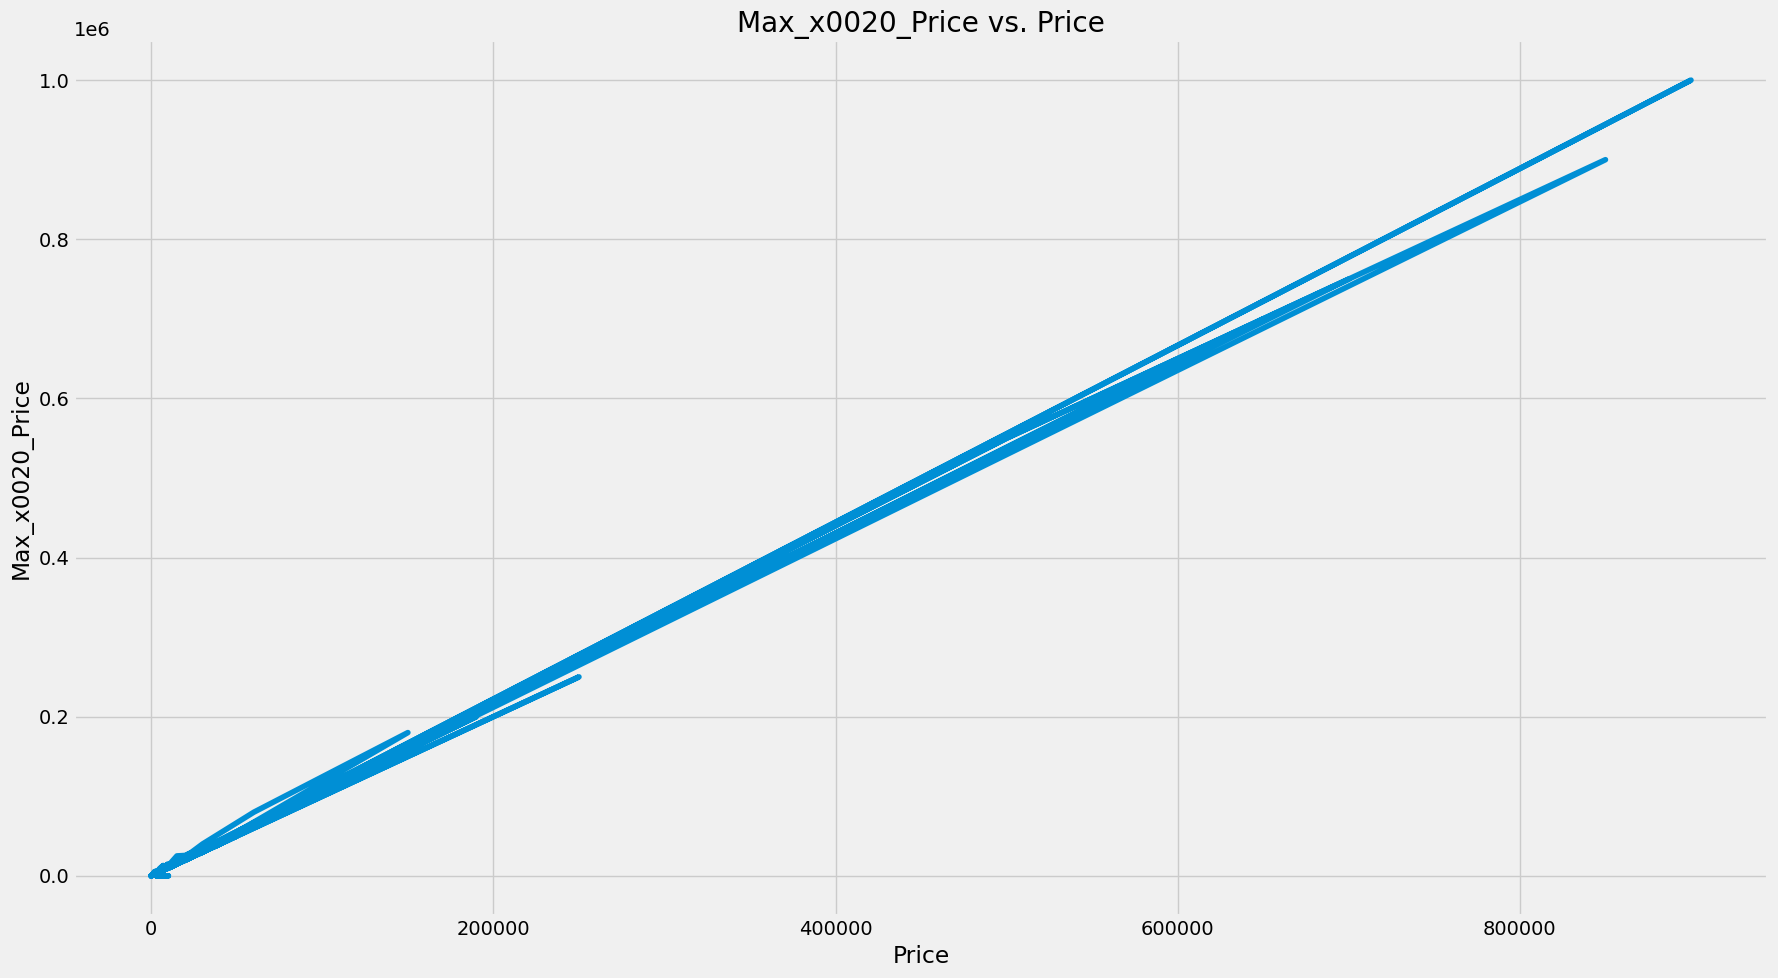

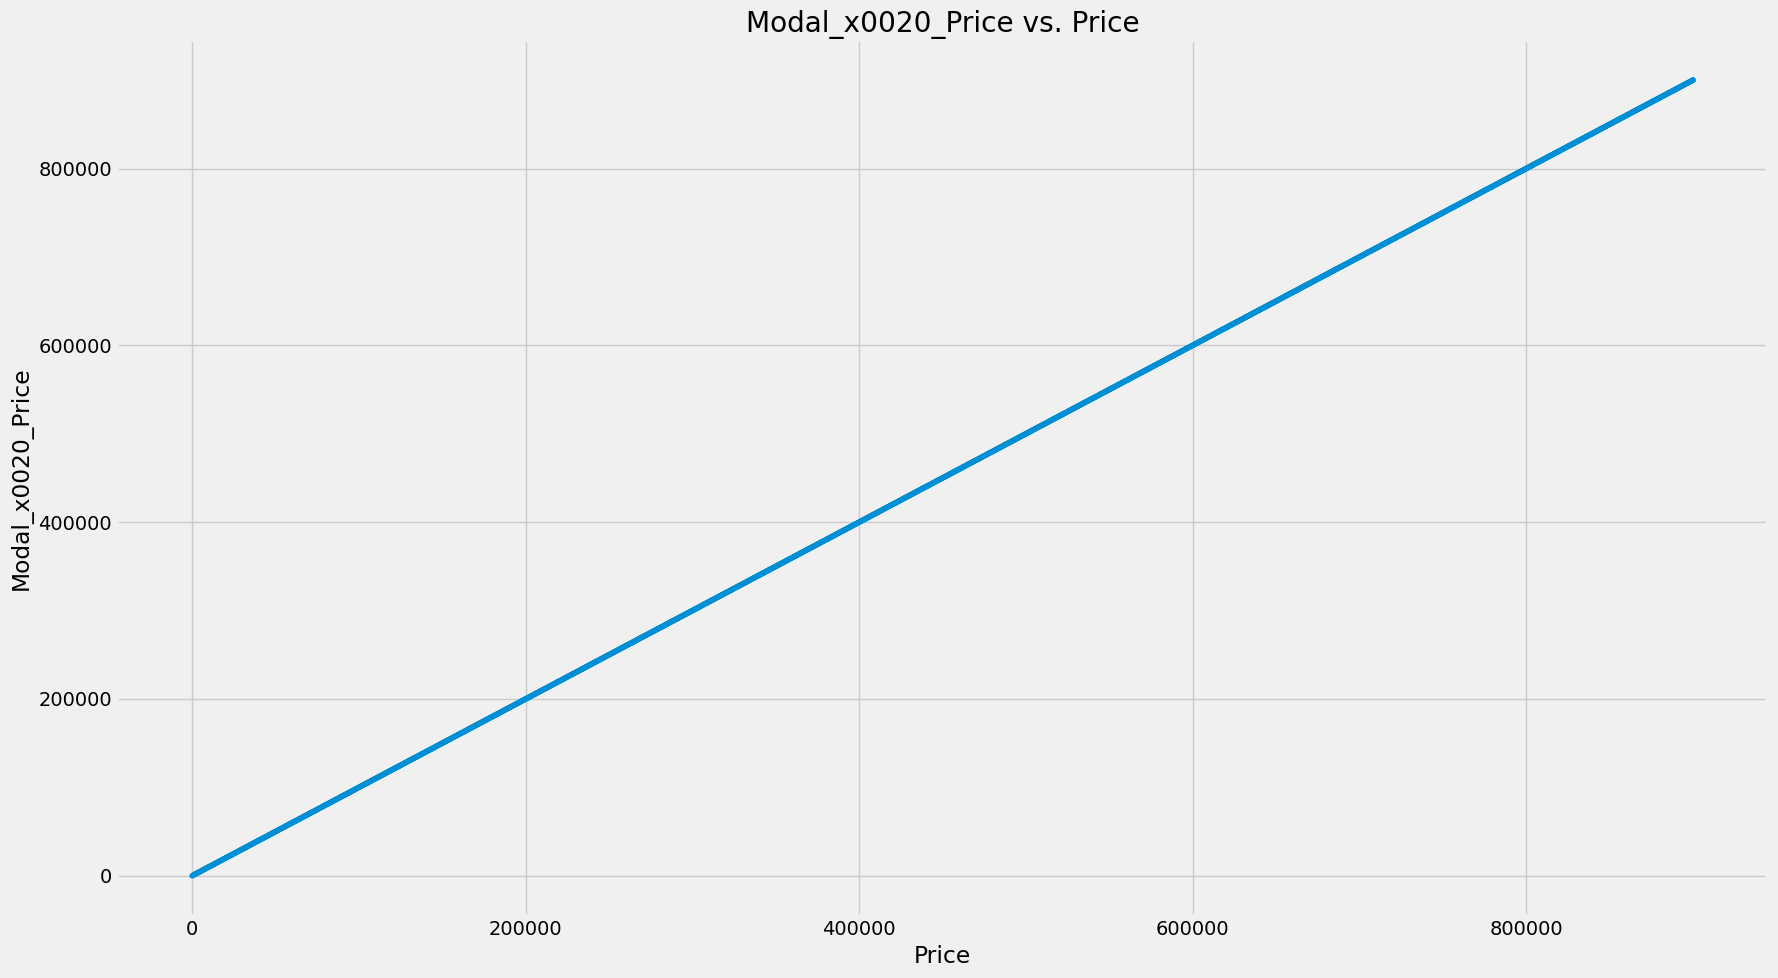

In [ ]:
#Plot all the variables against the Date/Price and check for the relationships, patterns and trends
for column in data.columns[2:]:
    plt.figure(figsize=(18,10))
    plt.plot(data['Modal_x0020_Price'], data[column])
    plt.xlabel('Price')
    plt.ylabel(column)
    plt.title(f'{column} vs. Price')
    plt.tight_layout()
    plt.show()


In [ ]:
# Define a function which will give us rolling mean and standard deviation and perform ADF Test
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')

    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop

    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

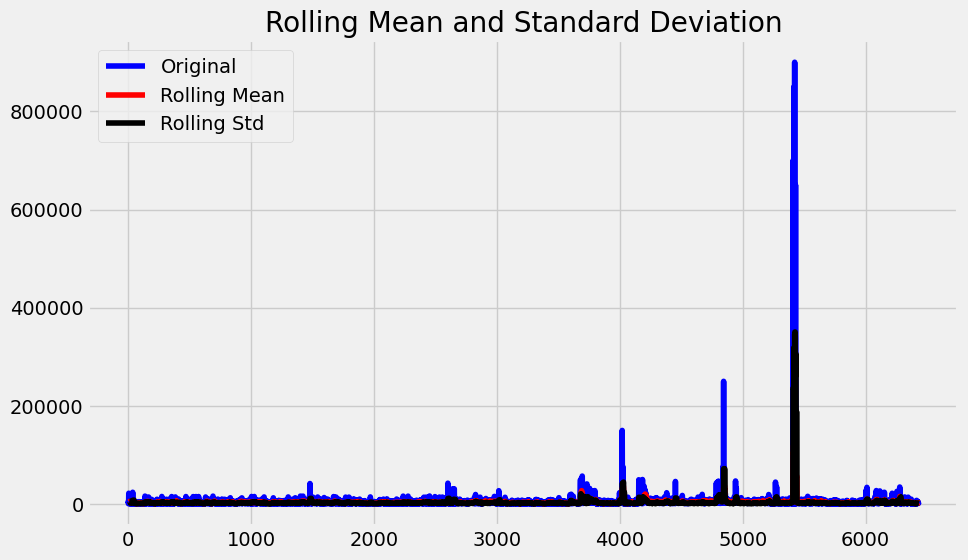

Results of dickey fuller test
Test Statistics               -1.035924e+01
p-value                        2.420785e-18
No. of lags used               3.200000e+01
Number of observations used    6.402000e+03
critical value (1%)           -3.431372e+00
critical value (5%)           -2.861992e+00
critical value (10%)          -2.567010e+00
dtype: float64


In [ ]:
test_stationarity(data['Modal_x0020_Price'])

<Figure size 1000x600 with 0 Axes>

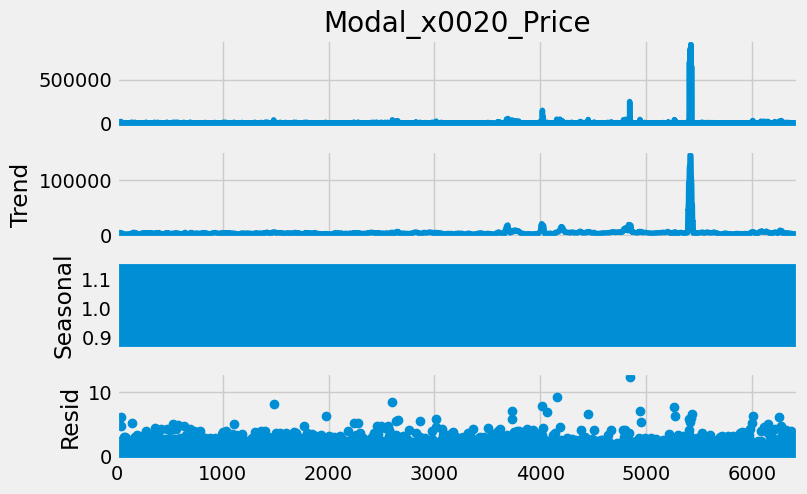

In [ ]:
# Decompose the series to separate the trend and the seasonality from a time series,
result = seasonal_decompose(data['Modal_x0020_Price'], model='multiplicative', period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(8, 5)

In [ ]:
def test_stationarity(timeseries):

    # Transformation to make the data stationary
    timeseries_log = np.log(timeseries)
    timeseries_log_diff = timeseries_log.diff().dropna()

    # Determing rolling statistics
    rolmean = timeseries_log_diff.rolling(window=12).mean()
    rolstd = timeseries_log_diff.rolling(window=12).std()

    # Plot rolling statistics
    plt.figure(figsize=(6, 4))
    plt.plot(timeseries_log_diff, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.xlabel('Date')
    plt.ylabel('Log-Difference')
    plt.show()

    # Perform ADF test
    adft = adfuller(timeseries_log_diff, autolag='AIC')

    # Output the ADF test results
    output = pd.Series(adft[0:4], index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key, value in adft[4].items():
        output[f'Critical Value ({key})'] = value
    print(output)

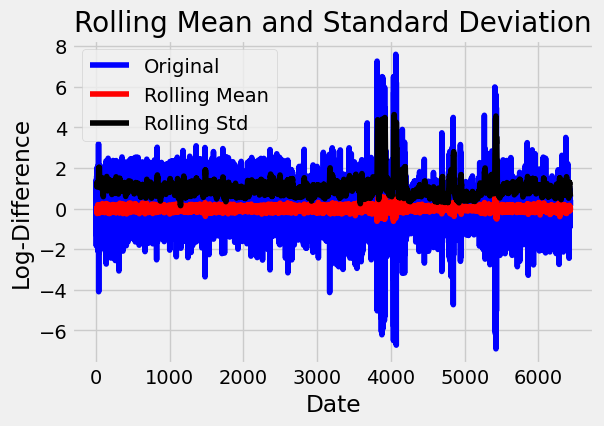

Test Statistic                  -22.053812
p-value                           0.000000
Number of Lags Used              30.000000
Number of Observations Used    6403.000000
Critical Value (1%)              -3.431372
Critical Value (5%)              -2.861992
Critical Value (10%)             -2.567010
dtype: float64


In [ ]:
test_stationarity(data['Modal_x0020_Price'])

-----------------------------------------------------------
-----------STOCK PRICE PREDICTION BY MOVING AVERAGE--------
-----------------------------------------------------------
Shape of Training Set: (5792, 1)
Shape of Validation Set: (643, 1)
RMSE value on validation set: 0.9226202892600539
-----------------------------------------------------------


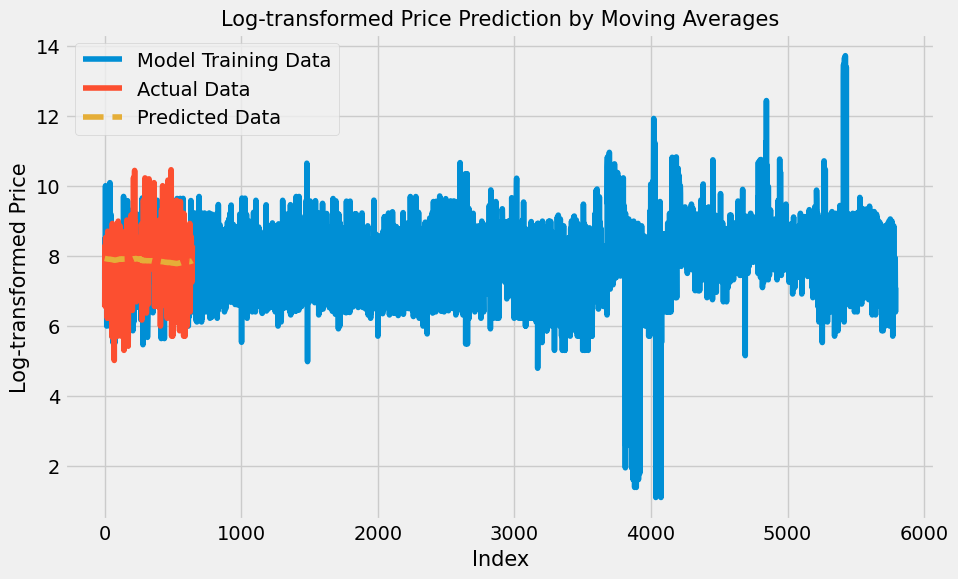

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil  # Import ceil function for rounding

def moving_avg_prediction(data):
    shape = data.shape[0]
    df_new = data[['Modal_x0020_Price']]
    df_new['Modal_x0020_Price'] = np.log(df_new['Modal_x0020_Price'])  # Apply logarithmic transformation

    # Split data into training and validation sets
    train_set = df_new.iloc[:ceil(shape * 0.9)]
    valid_set = df_new.iloc[ceil(shape * 0.9):]

    print('-----------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY MOVING AVERAGE--------')
    print('-----------------------------------------------------------')
    print('Shape of Training Set:', train_set.shape)
    print('Shape of Validation Set:', valid_set.shape)

    # Calculate moving average predictions
    preds = []
    for i in range(0, valid_set.shape[0]):
        a = train_set['Modal_x0020_Price'][len(train_set) - valid_set.shape[0] + i:].sum() + sum(preds)
        b = a / (valid_set.shape[0])
        preds.append(b)

    # Adjust length of predictions to match validation length if necessary
    if len(preds) != len(valid_set):
        print('Length mismatch detected. Adjusting predictions to match validation length.')
        preds = preds[:len(valid_set)]

    # Calculate RMSE for validation set
    rms = np.sqrt(np.mean(np.power(np.array(valid_set['Modal_x0020_Price']) - np.array(preds), 2)))
    print('RMSE value on validation set:', rms)
    print('-----------------------------------------------------------')

    # Add predictions to validation set and plot results
    valid_set['Predictions'] = preds

    plt.figure(figsize=(10, 6))
    plt.plot(train_set['Modal_x0020_Price'].values, label='Model Training Data')
    plt.plot(valid_set['Modal_x0020_Price'].values, label='Actual Data')
    plt.plot(valid_set['Predictions'].values, label='Predicted Data', linestyle='--')

    plt.xlabel('Index', size=15)
    plt.ylabel('Log-transformed Price', size=15)
    plt.title('Log-transformed Price Prediction by Moving Averages', size=15)
    plt.legend()
    plt.show()

# Example Usage
moving_avg_prediction(data)


In [ ]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

def fetch_data_with_retries(url):
    session = requests.Session()
    retry = Retry(total=5, backoff_factor=1, status_forcelist=[500, 502, 503, 504])
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)

    try:
        response = session.get(url, timeout=10)  # Set a timeout
        response.raise_for_status()  # Raise an HTTPError for bad responses
        return response.json()  # Assuming JSON response
    except requests.RequestException as e:
        print(f"Error fetching data: {e}")
        return None

# Example URL - replace with the actual URL
api_url = 'https://fci.gov.in/headquarter/'
data = fetch_data_with_retries(api_url)
print(data)


----------------------------------------------------------
------- STOCK PRICE PREDICTION USING RAG APPROACH --------
----------------------------------------------------------
Shape of Training Set: (5791, 1)
Shape of Validation Set: (644, 1)
Length of Combined Data: 5891
Length of X_valid: 644
Length of Valid Set: 644
RMSE value on validation set: 1.4794524751401887
-----------------------------------------------------------


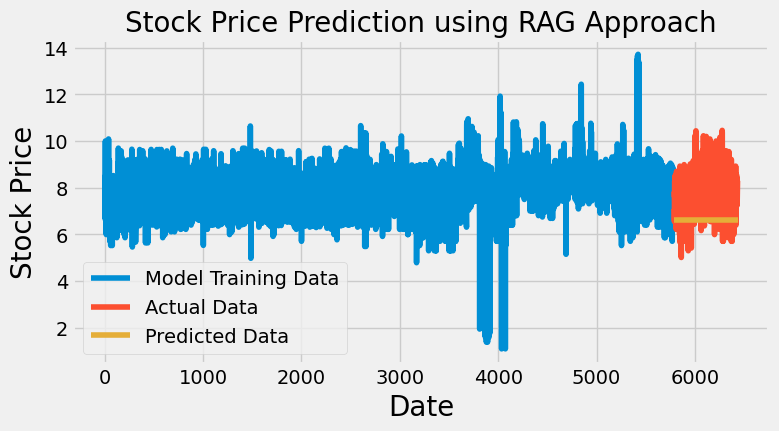

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
# (agri_data.head())

# Mock function to simulate real-time data fetching
def get_real_time_stock_data():
    # Example: Creating a mock dataframe
    # In practice, replace this with actual API calls
    mock_data = {
        'Modal_x0020_Price': np.random.normal(loc=100, scale=10, size=100)  # Random data
    }
    return pd.DataFrame(mock_data)

# RAG Function for Prediction
def moving_avg_prediction(data):
    # Step 1: Logarithmic transformation and splitting data
    shape = data.shape[0]
    df_new = data[['Modal_x0020_Price']]
    df_new['Modal_x0020_Price'] = np.log(df_new['Modal_x0020_Price'])  # Apply logarithmic transformation

    train_set = df_new.iloc[:int(shape * 0.9)]
    valid_set = df_new.iloc[int(shape * 0.9):]

    print('----------------------------------------------------------')
    print('------- STOCK PRICE PREDICTION USING RAG APPROACH --------')
    print('----------------------------------------------------------')
    print('Shape of Training Set:', train_set.shape)
    print('Shape of Validation Set:', valid_set.shape)

    # Step 2: Training with historical data
    X_train = np.arange(0, len(train_set)).reshape(-1, 1)  # Time as feature
    y_train = train_set['Modal_x0020_Price']

    # Step 3: Fetching real-time stock data from API (using mock data here)
    real_time_data = get_real_time_stock_data()
    real_time_data['Modal_x0020_Price'] = np.log(real_time_data['Modal_x0020_Price'])
    combined_data = pd.concat([train_set, real_time_data], ignore_index=True)

    # Check lengths of combined data
    print('Length of Combined Data:', len(combined_data))

    # Step 4: Train the model (using RandomForest as an example)
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Step 5: Predict future prices using validation set
    X_valid = np.arange(len(train_set), len(train_set) + len(valid_set)).reshape(-1, 1)

    # Ensure the length of X_valid matches the length of validation data
    print('Length of X_valid:', len(X_valid))
    print('Length of Valid Set:', len(valid_set))

    y_valid = valid_set['Modal_x0020_Price']
    y_pred = rf_model.predict(X_valid)

    if len(y_valid) != len(y_pred):
        print('Length mismatch detected. Adjusting predictions to match validation length.')
        # Adjust predictions to match the length of y_valid if necessary
        y_pred = y_pred[:len(y_valid)]

    # Step 6: Evaluate the model
    rms = np.sqrt(mean_squared_error(y_valid, y_pred))
    print('RMSE value on validation set:', rms)
    print('-----------------------------------------------------------')

    # Step 7: Plotting results
    plt.figure(figsize=(8, 4))
    plt.plot(np.arange(len(train_set)), train_set['Modal_x0020_Price'], label='Model Training Data')
    plt.plot(np.arange(len(train_set), len(train_set) + len(valid_set)), valid_set['Modal_x0020_Price'], label='Actual Data')
    plt.plot(np.arange(len(train_set), len(train_set) + len(valid_set)), y_pred, label='Predicted Data')

    plt.xlabel('Date', size=20)
    plt.ylabel('Stock Price', size=20)
    plt.title('Stock Price Prediction using RAG Approach', size=20)
    plt.legend(['Model Training Data', 'Actual Data', 'Predicted Data'])
    plt.show()

# Example Usage
moving_avg_prediction(data)
